![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir si el precio del automóvil es alto o no. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

# Visualización dataset
data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
7,2014,6480,0,0,0,1,0,0,0,1
11,2014,39972,0,0,0,0,1,0,0,0
167,2016,18989,0,0,0,0,0,1,0,1
225,2014,51330,0,0,0,1,0,0,0,0
270,2007,116065,0,1,0,0,0,0,0,0


In [3]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [4]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el acurracy del modelo en el set de test.

In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.metrics import mean_squared_error,accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()*2 + (1 - y.mean())*2)
    
# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_
# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

# Aplicación de la función tree_grow
tree = tree_grow(X_train, y_train)

# Predicciones 
y_pred_dt = tree_predict(X_test, tree)

print('Accuracy: ', accuracy_score(y_test, y_pred_dt))

Accuracy:  0.5848729792147807


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de clasificación y comenten sobre el desempeño del modelo.

In [7]:
# Creación de 100 muestras de bootstrap
n_estimators = 10
np.random.seed(123)

n_samples = X_train.shape[0]
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]

In [8]:
# Entrenamiento de 100 modelos con las 100 muestras boostrap

from sklearn.tree import DecisionTreeClassifier

np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_estimators)

trees = {}
for i in range(n_estimators):
    trees[i] = DecisionTreeClassifier(max_features=None, max_depth=None, random_state=seeds[i])
    trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])

In [9]:
# Predicción para los datos del set de test con cada modelo
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = trees[i].predict(X_test)

y_pred_df.head()

,0,1,2,3,4,5,6,7,8,9
257343,0,0,0,0,0,0,0,0,0,0
326011,0,0,0,0,0,0,0,0,0,0
242354,1,1,1,1,1,1,1,1,1,1
266376,1,1,1,1,1,1,1,1,1,1
396954,1,1,1,1,1,1,1,1,1,1


In [10]:
# Impresión de la cantidad de modelos que predijeron 1 para 10 observaciones
y_pred_df.sum(axis=1)[:10]

257343     0
326011     0
242354    10
266376    10
396954    10
317876     0
127182     0
187272     5
372243     7
254404    10
dtype: int64

In [11]:
# Votación mayoritaria
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

# Desempeño al hacer votación mayoritaria
from sklearn import metrics
metrics.f1_score(y_pred, y_test)

0.8755782809836863

In [12]:
# Desempeño al hacer votación mayoritaria
metrics.accuracy_score(y_pred, y_test)

0.8524826789838337

Al encontrarnos con un problema de clasificacion , se realiza un Bagging Manual con la metodología de votacion mayoritaria obteniendo un Accuracy de 88.4% el cual es bastante alto.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de clasificación y el parámetro `max_features` igual a `log(n_features)`. Presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [13]:
# Celda 3
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import BaggingClassifier
from math import log
from sklearn.tree import  DecisionTreeClassifier

bagreg = BaggingClassifier(DecisionTreeClassifier(max_features=int(round(log(9),0)), max_depth=10), n_estimators=10, 
                          bootstrap=True, oob_score=True, random_state=1)

In [14]:
bagreg.fit(X_train, y_train)
y_pred = bagreg.predict(X_test)
y_pred

array([0, 0, 1, ..., 1, 0, 0])

In [15]:
# Cálculo del error del modelo
np.sqrt(mean_squared_error(y_test, y_pred))

0.35150616208843793

In [16]:
metrics.accuracy_score(y_pred, y_test)

0.8764434180138568

Al realizar el Baging por libreria obtenemos un Accuracy de 87.8% el cual sigui siendo bueno aunque con un resultado inferior al obtenido mediante Bagging manual.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para clasificación y presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [17]:
# Celda 4

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

clf = RandomForestClassifier()
clf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [18]:
#Impresión de desempeño del modelo usando la función cross_val_score  (más detalles en https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)
pd.Series(cross_val_score(clf, X, y, cv=10)).describe()

count    10.000000
mean      0.836586
std       0.011633
min       0.815062
25%       0.832261
50%       0.834207
75%       0.847106
max       0.850476
dtype: float64

In [19]:
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(10, 310, 10)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

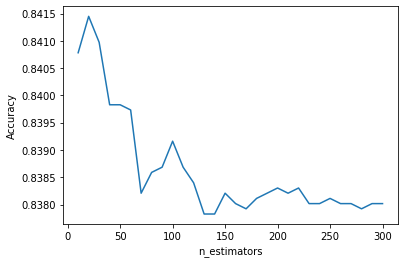

In [20]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

In [21]:
from statistics import mean
mean(accuracy_scores)


0.8386469747498808

In [22]:
RF_Sin_Calibrar=max(accuracy_scores)
RF_Sin_Calibrar

0.8414483087184375

Tras estimar el modelo mediante random forest para 300 estimaciones obtenemos que en promedio obtuvimos un accuracy de 83.86% el cual a pesar de tener un nivel de precision aceptable se encuentra por debajo de los metodos de Baging manual y bagging por libreria.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

In [23]:
feature_cols = data.columns[data.columns.str.startswith('C') == False].drop('HighPrice')
feature_cols

Index(['Year', 'Mileage', 'M_Camry', 'M_Camry4dr', 'M_CamryBase', 'M_CamryL',
       'M_CamryLE', 'M_CamrySE', 'M_CamryXLE'],
      dtype='object')

In [24]:
# Celda 5
# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_range = range(1, len(feature_cols)+1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_features
accuracy_scores = []

# Uso de un 10-fold cross-validation para cada valor de max_features
for feature in feature_range:
    clf = RandomForestClassifier(n_estimators=500, max_depth=None, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

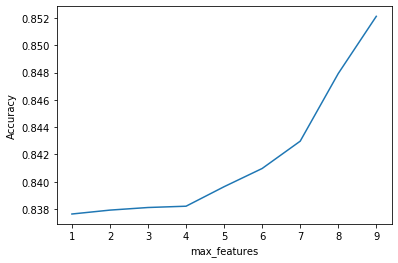

In [25]:
# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

In [26]:
# Definición del modelo con los parámetros max_features=6 y n_estimators=200 
clf = RandomForestClassifier(n_estimators=40, max_features=9, random_state=1, n_jobs=-1)
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=9,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                       oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [27]:
# Impresión de resultados de desemepeño del modelo
pd.DataFrame({'feature':feature_cols, 'importance':clf.feature_importances_}).sort_values('importance')

,feature,importance
4,M_CamryBase,0.000042
3,M_Camry4dr,0.001284
5,M_CamryL,0.004820
7,M_CamrySE,0.006289
2,M_Camry,0.007808
8,M_CamryXLE,0.008101
6,M_CamryLE,0.016121
0,Year,0.163179
1,Mileage,0.792357


In [28]:
accuracy_scores = []
for estimator in estimator_range:
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

In [29]:
RF_Calibrado=max(accuracy_scores)
RF_Calibrado

0.8516436398284897

Tras calibrar la profundidad, el numero de estimadores y el numero de variables que maximizaban el accuracy del modelo mediante Random Forest obtenemos que en promedio el accuracy paso de 83.8% a 85.2% lo cual mejora la precision del modelo, aunque sigue estando por debajo del bagging manual.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de clasificación con la librería sklearn, presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [30]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [31]:
# Celda 6
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
clf = XGBClassifier()
clf

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='binary:logistic',
              predictor=None, random_state=None, reg_alpha=None, ...)

In [32]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.f1_score(y_pred, y_test.values), metrics.accuracy_score(y_pred, y_test.values)

(0.9047160731472569, 0.8856812933025404)

Al estimar el modelo mediante XGBoost sin calibrar obtenemos un Accuracy de 88.5% el cual resulta superior al modelo que hasta ahora punteaba como el mejor ( Bagging manual).

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

In [33]:
# Celda 7
CLF2=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=1,
              enable_categorical=False, gamma=19, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=19, max_delta_step=None, max_depth=None,
              min_child_weight=None, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None)

In [34]:
CLF2.fit(X_train, y_train)
y_pred = CLF2.predict(X_test)
metrics.f1_score(y_pred, y_test.values), metrics.accuracy_score(y_pred, y_test.values)

(0.9057867049258729, 0.8862586605080831)

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

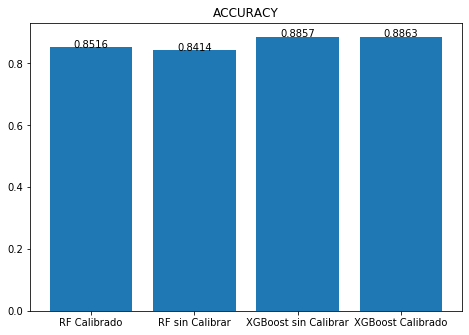

In [35]:
# Celda 8

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("ACCURACY")
XGBoost=0.8856812933025404
XGBoost_Calibrado=0.8862586605080831
ejeX = ['RF Calibrado', 'RF sin Calibrar','XGBoost sin Calibrar','XGBoost Calibrado']
ejeY = [RF_Calibrado,RF_Sin_Calibrar,XGBoost,XGBoost_Calibrado]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,round(y[i], 4), round(y[i], 4), ha="center")
addlabels(ejeX,ejeY,plt)
plt.show()

Al comprar el Accuracy de los modelos realizados observamos que el modelo XGBoost Calibrado es el que mejor Accuracy presenta con un 86.63% superando todos los modelos construidos en este ejercicio, sin embargo al comprar el mejor modelo de XGBoost con el Random Forest Calibrado es posible entrar en la discusion si el ajuste ganado por XGBoost compensa el mayor esfuerzo computacional con respecto al Random Forest.

Sin duda la discusion sobre cual es el mejor modelo para mi problema dependera sobre el peso que le damos a un mejor nivel de ajuste vs un mayor costo cumputacional.